##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 高级自动微分

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/advanced_autodiff"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png"> 在  TensorFlow.org 上查看</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/advanced_autodiff.ipynb">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png">     在 Google Colab 中运行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/advanced_autodiff.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png"> 在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/advanced_autodiff.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png"> 下载笔记本</a></td>
</table>

[梯度和自动微分简介](autodiff.ipynb)指南包括在 TensorFlow 中计算梯度所需的全部内容。本指南重点介绍 `tf.GradientTape` API 更深入、更不常见的功能。

## 设置

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)

2022-12-14 22:53:27.845325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:53:27.845442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:53:27.845452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 控制梯度记录

在[自动微分指南](autodiff.ipynb)中，您已了解构建梯度计算时如何控制条带监视变量和张量。

条带还具有操作记录的方法。

### 停止记录

如果您希望停止记录梯度，可以使用 `tf.GradientTape.stop_recording` 暂时挂起记录。

如果您不希望在模型中间对复杂运算微分，这可能有助于减少开销。其中可能包括计算指标或中间结果：

In [3]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  x_sq = x * x
  with t.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


### 重置/从头开始纪录

如果您希望完全重新开始，请使用 `tf.GradientTape.reset`。通常，直接退出梯度带块并重新开始比较易于读取，但在退出梯度带块有困难或不可行时，可以使用 `reset` 方法。

In [4]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far.
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 精确停止梯度流

与上面的全局条带控制相比，`tf.stop_gradient` 函数更加精确。它可以用来阻止梯度沿着特定路径流动，而不需要访问条带本身：

In [5]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 自定义梯度

在某些情况下，您可能需要精确控制梯度的计算方式，而不是使用默认值。这些情况包括：

1. 正在编写的新运算没有定义的梯度。
2. 默认计算在数值上不稳定。
3. 您希望从前向传递缓存开销大的计算。
4. 您想修改一个值（例如，使用 `tf.clip_by_value` 或 `tf.math.round`）而不修改梯度。

对于第一种情况，要编写新运算，您可以使用 `tf.RegisterGradient` 自行设置。（请参阅 API 文档了解详细信息）。（注意，梯度注册为全局，需谨慎更改。）

对于后三种情况，可以使用 `tf.custom_gradient`。

以下示例将 `tf.clip_by_norm` 应用于中间梯度：

In [6]:
# Establish an identity operation, but clip during the gradient pass.
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
  output = clip_gradients(v * v)
print(t.gradient(output, v))  # calls "backward", which clips 4 to 2

tf.Tensor(2.0, shape=(), dtype=float32)


请参阅 `tf.custom_gradient` 装饰器 API 文档，了解更多详细信息。

### SavedModel 中的自定义梯度

注：此功能将从 TensorFlow 2.6 开始提供。

可以使用选项 `tf.saved_model.SaveOptions(experimental_custom_gradients=True)` 将自定义梯度保存到 SavedModel。

要保存到 SavedModel，梯度函数必须可以跟踪（要了解详情，请参阅[使用 tf.function 提高性能](function.ipynb)指南）。

In [7]:
class MyModule(tf.Module):

  @tf.function(input_signature=[tf.TensorSpec(None)])
  def call_custom_grad(self, x):
    return clip_gradients(x)

model = MyModule()

In [8]:
tf.saved_model.save(
    model,
    'saved_model',
    options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

# The loaded gradients will be the same as the above example.
v = tf.Variable(2.0)
loaded = tf.saved_model.load('saved_model')
with tf.GradientTape() as t:
  output = loaded.call_custom_grad(v * v)
print(t.gradient(output, v))

INFO:tensorflow:Assets written to: saved_model/assets


tf.Tensor(2.0, shape=(), dtype=float32)


关于上述示例的注意事项：如果您尝试用 `tf.saved_model.SaveOptions(experimental_custom_gradients=False)` 替换上面的代码，梯度仍会在加载时产生相同的结果。原因在于，梯度注册表仍然包含函数 `call_custom_op` 中使用的自定义梯度。但是，如果在没有自定义梯度的情况下保存后重新启动运行时，则在 `tf.GradientTape` 下运行加载的模型会抛出错误：`LookupError: No gradient defined for operation 'IdentityN' (op type: IdentityN)`。

## 多个条带

多个条带无缝交互。

例如，下面每个条带监视不同的张量集：

In [9]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)

In [10]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

1.0

In [11]:
tape1.gradient(ys, x1).numpy()   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25

0.25

### 高阶梯度

`tf.GradientTape` 上下文管理器内的运算会被记录下来，以供自动微分。如果在该上下文中计算梯度，梯度计算也会被记录。因此，完全相同的 API 也适用于高阶梯度。

例如：

In [12]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


虽然这确实可以得到*标量*函数的二次导数，但这种模式并不能通用于生成黑塞矩阵，因为 `tf.GradientTape.gradient` 只计算标量的梯度。要构造[黑塞矩阵](https://en.wikipedia.org/wiki/Hessian_matrix)，请参见[“雅可比矩阵”部分](https://en.wikipedia.org/wiki/Hessian_matrix)下的[“黑塞矩阵”示例](#hessian)。

当您从梯度计算标量，然后产生的标量作为第二个梯度计算的源时，“嵌套调用 `tf.GradientTape.gradient`”是一种不错的模式，如以下示例所示。


#### 示例：输入梯度正则化

许多模型都容易受到“对抗样本”影响。这种技术的集合会修改模型的输入，进而混淆模型输出。最简单的实现（例如，[使用 Fast Gradient Signed Method 攻击的对抗样本](https://tensorflow.google.cn/tutorials/generative/adversarial_fgsm)）沿着输出相对于输入的梯度（即“输入梯度”） 迈出一步。

一种增强相对于对抗样本的稳健性的方法是[输入梯度正则化](https://arxiv.org/abs/1905.11468)（Finlay 和 Oberman，2019 年），这种方法会尝试将输入梯度的幅度最小化。如果输入梯度较小，那么输出的变化也应该较小。

以下是输入梯度正则化的简单实现：

1. 使用内条带计算输出相对于输入的梯度。
2. 计算该输入梯度的幅度。
3. 计算该幅度相对于模型的梯度。

In [13]:
x = tf.random.normal([7, 5])

layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

In [14]:
with tf.GradientTape() as t2:
  # The inner tape only takes the gradient with respect to the input,
  # not the variables.
  with tf.GradientTape(watch_accessed_variables=False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x)**2)
  # 1. Calculate the input gradient.
  g1 = t1.gradient(out, x)
  # 2. Calculate the magnitude of the input gradient.
  g1_mag = tf.norm(g1)

# 3. Calculate the gradient of the magnitude with respect to the model.
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)

In [15]:
[var.shape for var in dg1_mag]

[TensorShape([5, 10]), TensorShape([10])]

## 雅可比矩阵


以上所有示例都取标量目标相对于某些源张量的梯度。

[雅可比矩阵](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)代表向量值函数的梯度。每行都包含其中一个向量元素的梯度。

`tf.GradientTape.jacobian` 方法让您能够有效计算雅可比矩阵。

注意：

- 类似于 `gradient`：`sources` 参数可以是张量或张量的容器。
- 不同于 `gradient`：`target` 张量必须是单个张量。

### 标量源

作为第一个示例，以下是矢量目标相对于标量源的雅可比矩阵。

In [16]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

当您相对于标量取雅可比矩阵时，结果为**目标**的形状，并给出每个元素相对于源的梯度：

In [17]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


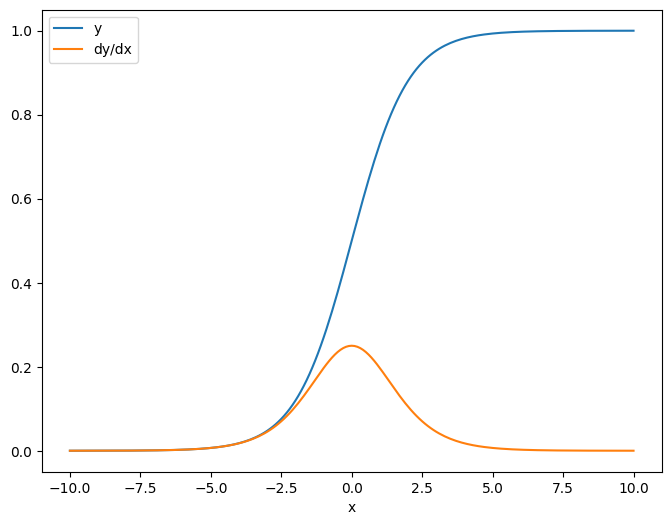

In [18]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

### 张量源

无论输入是标量还是张量，`tf.GradientTape.jacobian` 都能有效计算源的每个元素相对于目标的每个元素的梯度。

例如，此层的输出的形状为 `(10，7)`。

In [19]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

y.shape

TensorShape([7, 10])

层内核的形状是 `(5，10)`。

In [20]:
layer.kernel.shape

TensorShape([5, 10])

将这两个形状连在一起就是输出相对于内核的雅可比矩阵的形状：

In [21]:
j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

如果您在目标的维度上求和，会得到由 `tf.GradientTape.gradient` 计算的总和的梯度：

In [22]:
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

g.shape: (5, 10)
delta: 4.7683716e-07


<a id="hessian"> </a>

#### 示例：黑塞矩阵

虽然 `tf.GradientTape` 并没有给出构造[黑塞矩阵](https://en.wikipedia.org/wiki/Hessian_matrix)的显式方法，但可以使用 <code>tf.GradientTape.jacobian</code> 方法进行构建。

注：黑塞矩阵包含 `N**2` 个参数。由于这个原因和其他原因，它对于大多数模型都不实际。此示例主要是为了演示如何使用 `tf.GradientTape.jacobian` 方法，并不是对直接黑塞矩阵优化的认可。黑塞矩阵向量积可以[通过嵌套条带有效计算](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/eager/benchmarks/resnet50/hvp_test.py)，这也是一种更有效的二阶优化方法。

In [23]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [24]:
print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


要将此黑塞矩阵用于[牛顿方法](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)步骤，首先需要将其轴展平为矩阵，然后将梯度展平为向量：

In [25]:
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

黑塞矩阵应当对称：

In [26]:
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

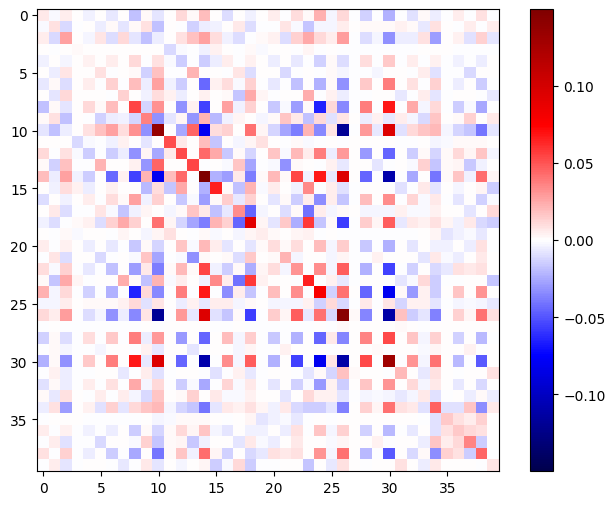

In [27]:
imshow_zero_center(h_mat)

牛顿方法更新步骤如下所示。

In [28]:
eps = 1e-3
eye_eps = tf.eye(h_mat.shape[0])*eps

注：[实际上不反转矩阵](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/)。

In [29]:
# X(k+1) = X(k) - (∇²f(X(k)))^-1 @ ∇f(X(k))
# h_mat = ∇²f(X(k))
# g_vec = ∇f(X(k))
update = tf.linalg.solve(h_mat + eye_eps, g_vec)

# Reshape the update and apply it to the variable.
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

虽然这对于单个 `tf.Variable` 来说相对简单，但将其应用于非平凡模型则需要仔细的级联和切片，以产生跨多个变量的完整黑塞矩阵。

### 批量雅可比矩阵

在某些情况下，您需要取各个目标堆栈相对于源堆栈的雅可比矩阵，其中每个目标-源对的雅可比矩阵都是独立的。

例如，此处的输入 `x` 形状为 `(batch, ins)` ，输出 `y` 形状为 `(batch, outs)`：


In [30]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)

y.shape

TensorShape([7, 6])

`y` 相对 `x` 的完整雅可比矩阵的形状为 `(batch, ins, batch, outs)`，即使您只想要 `(batch, ins, outs)`。

In [31]:
j = tape.jacobian(y, x)
j.shape

TensorShape([7, 6, 7, 5])

如果堆栈中各项的梯度相互独立，那么此张量的每一个 `(batch, batch)` 切片都是对角矩阵：

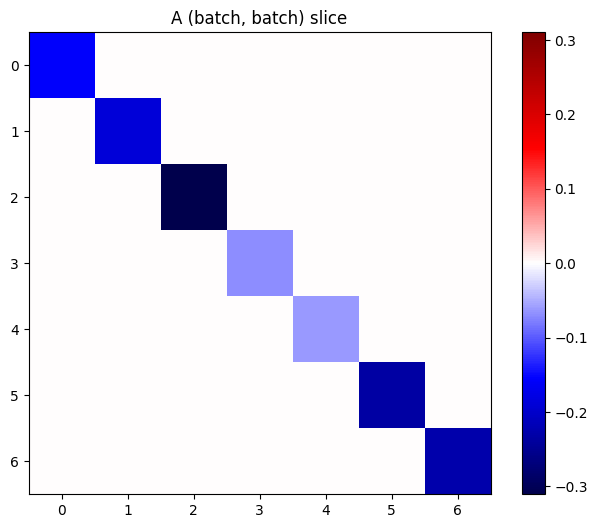

In [32]:
imshow_zero_center(j[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')

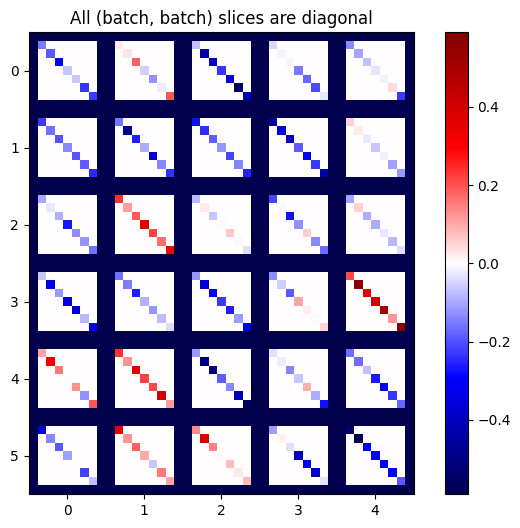

In [33]:
def plot_as_patches(j):
  # Reorder axes so the diagonals will each form a contiguous patch.
  j = tf.transpose(j, [1, 0, 3, 2])
  # Pad in between each patch.
  lim = tf.reduce_max(abs(j))
  j = tf.pad(j, [[0, 0], [1, 1], [0, 0], [1, 1]],
             constant_values=-lim)
  # Reshape to form a single image.
  s = j.shape
  j = tf.reshape(j, [s[0]*s[1], s[2]*s[3]])
  imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])

plot_as_patches(j)
_ = plt.title('All (batch, batch) slices are diagonal')

要获取所需结果，您可以对重复的 `batch` 维度求和，或者使用 `tf.einsum` 选择对角线：

In [34]:
j_sum = tf.reduce_sum(j, axis=2)
print(j_sum.shape)
j_select = tf.einsum('bxby->bxy', j)
print(j_select.shape)

(7, 6, 5)
(7, 6, 5)


没有额外维度时，计算会更加高效。`tf.GradientTape.batch_jacobian` 方法就是如此运作的：

In [35]:
jb = tape.batch_jacobian(y, x)
jb.shape

TensorShape([7, 6, 5])

In [36]:
error = tf.reduce_max(abs(jb - j_sum))
assert error < 1e-3
print(error.numpy())

0.0


小心：`tf.GradientTape.batch_jacobian` 只验证源和目标的第一维是否匹配，并不会检查梯度是否独立。用户需要确保仅在合理条件下使用 `batch_jacobian`。例如，添加 `tf.keras.layers.BatchNormalization` 将破坏独立性，因为它在 `batch` 维度进行了归一化：

In [37]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training=True)
  y = layer2(y)

j = tape.jacobian(y, x)
print(f'j.shape: {j.shape}')

j.shape: (7, 6, 7, 5)


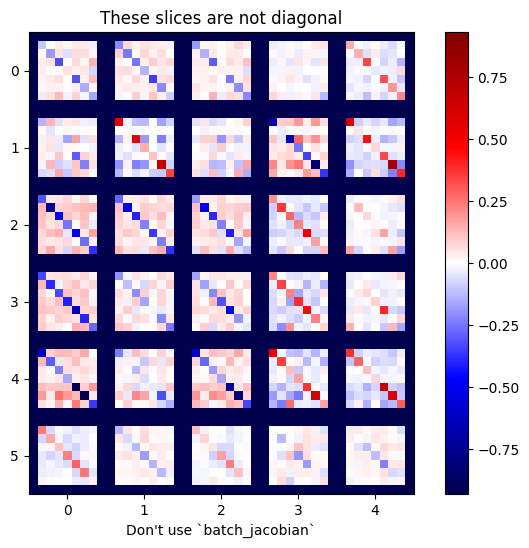

In [38]:
plot_as_patches(j)

_ = plt.title('These slices are not diagonal')
_ = plt.xlabel("Don't use `batch_jacobian`")

在此示例中，`batch_jacobian` 仍然可以运行并返回*某些信息*与预期形状，但其内容具有不明确的含义：

In [39]:
jb = tape.batch_jacobian(y, x)
print(f'jb.shape: {jb.shape}')

jb.shape: (7, 6, 5)
